# lasagne
* lasagne - это библиотека для написания нейронок произвольной формы на theano
* библиотека низкоуровневая, границы между theano и lasagne практически нет

В качестве демо-задачи выберем то же распознавание чисел, но на большем масштабе задачи
* картинки 28x28
* 10 цифр

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from mnist import load_dataset
X_train,y_train,X_val,y_val,X_test,y_test = load_dataset()

print X_train.shape,y_train.shape

(50000, 1, 28, 28) (50000,)


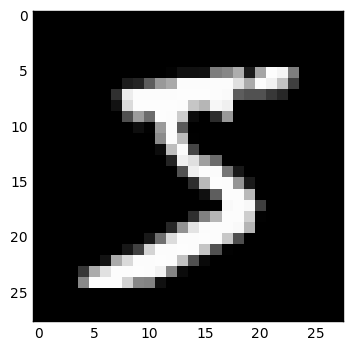

In [3]:
plt.imshow(X_train[0,0], cmap = 'gray', interpolation = 'none')

In [4]:
import lasagne
from theano import tensor as T
from lasagne.nonlinearities import *

input_X = T.tensor4("X")
target_y = T.vector("target Y integer",dtype='int32')

Так задаётся архитектура нейронки

In [5]:
#входной слой (вспомогательный)
input_layer = lasagne.layers.InputLayer(shape=(None,1,28,28), input_var=input_X)

#полносвязный слой, который принимает на вход input layer и имеет 100 нейронов.
# нелинейная функция - сигмоида как в логистической регрессии
# слоям тоже можно давать имена, но это необязательно
dense_1 = lasagne.layers.DenseLayer(input_layer,num_units=100, nonlinearity=sigmoid, name="hidden_dense_layer")

#ВЫХОДНОЙ полносвязный слой, который принимает на вход dense_1 и имеет 10 нейронов -по нейрону на цифру
#нелинейность - softmax - чтобы вероятности всех цифр давали в сумме 1
dense_output = lasagne.layers.DenseLayer(dense_1,num_units = 10, nonlinearity=softmax)

In [6]:
#предсказание нейронки (theano-преобразование)
y_predicted = lasagne.layers.get_output(dense_output)

In [7]:
#все веса нейронки (shared-переменные)
all_weights = lasagne.layers.get_all_params(dense_output)
print all_weights

[hidden_dense_layer.W, hidden_dense_layer.b, W, b]


### дальше вы могли бы просто
* задать функцию ошибки вручную
* посчитать градиент ошибки по all_weights
* написать updates
* но это долго, а простой шаг по градиенту - не самый лучший смособ оптимизировать веса

Вместо этого, опять используем lasagne

In [8]:
#функция ошибки - средняя кроссэнтропия
loss = lasagne.objectives.categorical_crossentropy(y_predicted,target_y).mean()

accuracy = lasagne.objectives.categorical_accuracy(y_predicted,target_y).mean()

#сразу посчитать словарь обновлённых значений с шагом по градиенту, как раньше
updates_sgd = lasagne.updates.rmsprop(loss, all_weights,learning_rate=0.01)

In [9]:
#функция, которая обучает сеть на 1 шаг и возвращащет значение функции потерь и точности
train_fun = theano.function([input_X,target_y],[loss,accuracy],updates= updates_sgd)

#функция, которая считает точность
accuracy_fun = theano.function([input_X,target_y],accuracy)

### Вот и всё, пошли её учить
* данных теперь много, поэтому лучше учиться стохастическим градиентным спуском
* для этого напишем функцию, которая бьёт выпорку на мини-батчи (в обычном питоне, не в theano)

In [10]:
# вспомогательная функция, которая возвращает список мини-батчей для обучения нейронки

#на вход
# inputs - тензор из картинок размером (много, 1, 28, 28), например - X_train
# targets - вектор из чиселок - ответов для каждой картинки из X; например - Y_train
# batchsize - одно число - желаемый размер группы

#что нужно сделать
# 1) перемешать данные
# - важно перемешать targets и targets одним и тем же образом, чтобы сохранить соответствие картинки ответу на неё
# 3) побить данные на подгруппы так, чтобы в каждой подгруппе было batchsize картинок и ответов
# - если число картинок не делится на batchsize, одну подгруппу можно вернуть другого размера
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

# Процесс обучения

In [11]:
import time

num_epochs = 10 #количество проходов по данным

batch_size = 50 #размер мини-батча

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train,batch_size):
        inputs, targets = batch
        train_err_batch, train_acc_batch= train_fun(inputs, targets)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))

    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(
        train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(
        val_acc / val_batches * 100))

Epoch 1 of 10 took 1.965s
  training loss (in-iteration):		0.259902
  train accuracy:		92.23 %
  validation accuracy:		96.18 %
Epoch 2 of 10 took 1.641s
  training loss (in-iteration):		0.109264
  train accuracy:		96.72 %
  validation accuracy:		96.53 %
Epoch 3 of 10 took 1.963s
  training loss (in-iteration):		0.074230
  train accuracy:		97.84 %
  validation accuracy:		97.03 %
Epoch 4 of 10 took 1.908s
  training loss (in-iteration):		0.053345
  train accuracy:		98.44 %
  validation accuracy:		97.04 %
Epoch 5 of 10 took 1.662s
  training loss (in-iteration):		0.040528
  train accuracy:		98.80 %
  validation accuracy:		96.98 %
Epoch 6 of 10 took 1.689s
  training loss (in-iteration):		0.028922
  train accuracy:		99.17 %
  validation accuracy:		97.25 %
Epoch 7 of 10 took 1.583s
  training loss (in-iteration):		0.021312
  train accuracy:		99.41 %
  validation accuracy:		97.38 %
Epoch 8 of 10 took 1.588s
  training loss (in-iteration):		0.016605
  train accuracy:		99.57 %
  validation acc

In [12]:
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500):
    inputs, targets = batch
    acc = accuracy_fun(inputs, targets)
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

if test_acc / test_batches * 100 > 99:
    print "Achievement unlocked: колдун 80 уровня"
else:
    print "Нужно больше магии!"

Final results:
  test accuracy:		97.54 %
Нужно больше магии!


# Нейронка твоей мечты


* Задача - сделать нейронку, которая получит точность 99% на валидации (validation accuracy)
 * Вариант "is fine too" - 97.5%. 
 * Чем выше, тем лучше.
 
__ В конце есть мини-отчётик, который имеет смысл прочитать вначале и заполнять по ходу работы. __
 

## Что можно улучшить:



 * размер сети
   * бОльше нейронов, 
   * бОльше слоёв, 
   
 * регуляризация - чтобы не переобучалось
   * приплюсовать к функции ошибки какую-нибудь сумму квадратов весов
   * можно сделать вручную, а можно - http://lasagne.readthedocs.org/en/latest/modules/regularization.html
   * Dropout - для борьбы с переобучением
       * `lasagne.layers.DropoutLayer(предыдущий_слой, p=вероятность_занулить)`
   
 * Метод оптимизации - adam, rmsprop, nesterov_momentum, adadelta, adagrad и т.п.
   * сходятся быстрее и иногда - к лучшему оптимуму
   * имеет смысл поиграть с размером батча, количеством эпох и скоростью обучения
   
 * Наконец, можно поиграть с нелинейностями в скрытых слоях
   * tanh, relu, leaky relu, etc

In [13]:
from mnist import load_dataset
X_train,y_train,X_val,y_val,X_test,y_test = load_dataset()

print X_train.shape,y_train.shape

(50000, 1, 28, 28) (50000,)


In [19]:
import lasagne

input_X = T.tensor4("X")

#размерность входа (None означает "может изменяться")
input_shape = [None,1,28,28]

target_y = T.vector("target Y integer",dtype='int32')

In [44]:
#входной слой (вспомогательный)
input_layer = lasagne.layers.InputLayer(shape = (None, 1, 28, 28),input_var=input_X)
#<моя архитектура>
#dense_1 = lasagne.layers.DenseLayer(input_layer,num_units=100, nonlinearity=sigmoid, name="1")
dense_2 = lasagne.layers.DropoutLayer(input_layer, p=0.2)
dense_3 = lasagne.layers.DenseLayer(dense_2,num_units=4096, nonlinearity=sigmoid, name="3")
#dense_4 = lasagne.layers.DropoutLayer(dense_3, p=0.5)
#dense_5 = lasagne.layers.DenseLayer(dense_4,num_units=1024, nonlinearity=sigmoid, name="5")
#dense_6 = lasagne.layers.DropoutLayer(dense_5, p=0.5)
#dense_6 = lasagne.layers.DenseLayer(dense_6,num_units=512, nonlinearity=sigmoid, name="pre")
dense_pre = lasagne.layers.DropoutLayer(dense_3, p=0.5)

#ВЫХОДНОЙ полносвязный слой, который принимает на вход dense_1 и имеет 10 нейронов -по нейрону на цифру
#нелинейность - softmax - чтобы вероятности всех цифр давали в сумме 1
dense_output = lasagne.layers.DenseLayer(dense_pre,num_units = 10,
                                        nonlinearity = lasagne.nonlinearities.softmax,
                                        name='output')


In [45]:
#предсказание нейронки (theano-преобразование)
y_predicted = lasagne.layers.get_output(dense_output)

In [46]:
#все веса нейронки (shared-переменные)
all_weights = lasagne.layers.get_all_params(dense_output)
print all_weights

[3.W, 3.b, output.W, output.b]


In [47]:
#функция ошибки - средняя кроссэнтропия
loss = lasagne.objectives.categorical_crossentropy(y_predicted,target_y).mean()

#<возможно добавить регуляризатор>

accuracy = lasagne.objectives.categorical_accuracy(y_predicted,target_y).mean()

#сразу посчитать словарь обновлённых значений с шагом по градиенту, как раньше
updates_sgd = lasagne.updates.rmsprop(loss, all_weights,learning_rate=0.01)

In [48]:
#функция, которая обучает сеть на 1 шаг и возвращащет значение функции потерь и точности
train_fun = theano.function([input_X,target_y],[loss,accuracy],updates= updates_sgd)

#функция, которая считает точность
accuracy_fun = theano.function([input_X,target_y],accuracy)

In [ ]:
#итерации обучения

num_epochs = 10 #количество проходов по данным

batch_size = 50#размер мини-батча

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train,batch_size):
        inputs, targets = batch
        train_err_batch, train_acc_batch= train_fun(inputs, targets)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))

    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(
        train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(
        val_acc / val_batches * 100))

In [28]:
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500):
    inputs, targets = batch
    acc = accuracy_fun(inputs, targets)
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

Final results:
  test accuracy:		91.90 %
